In [2]:
# function should simply be imported from the other python file at some point 

import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import rioxarray as rxr
from dask.diagnostics import ProgressBar

In [3]:
# --- Set file paths ---
# Base directory for project outputs
dir_path = "/global/scratch/users/yougsanghvi"

# Specific folder for attribution results
attribution_output_folderpath = os.path.join(
    dir_path,
    "gdnat_era5_compare_output"
)

# Define the output filename
attribution_output_filename = "merged_data_panel_extended.csv"

# Construct the full file path for the output data
attribution_output_filepath = os.path.join(
    attribution_output_folderpath,
    attribution_output_filename
)

# --- Load data ---
# Read the CSV file into a pandas DataFrame
attribution_output_data = pd.read_csv(attribution_output_filepath)

# --- Data manipulation ---
# Calculate the difference between ERA5 and GDNAT predictions
attribution_output_data['diff_suicide'] = attribution_output_data['y_hat_era5'] - attribution_output_data['y_hat_gdnat']

In [4]:
# Define paths for usa county shapefile
usa_county_dir = os.path.join(dir_path, "shapefiles")
usa_county_filename = "tl_2016_us_county_mortality.shp"
usa_county_path = os.path.join(usa_county_dir, usa_county_filename)

# Loading in county shapefile
usa_counties = gpd.read_file(usa_county_path)

In [7]:
usa_counties

,ID_1,ID_2,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,ID_0,geometry
0,01,001,00161526,1001,Autauga,Autauga County,06,H1,G4020,None,33860,None,A,1539609015,25749942,+32.5322367,-086.6464395,244,"POLYGON ((-86.9031 32.54063, -86.90313 32.5410..."
1,01,003,00161527,1003,Baldwin,Baldwin County,06,H1,G4020,380,19300,None,A,4117584019,1133130502,+30.6592183,-087.7460666,244,"POLYGON ((-87.99068 30.55549, -87.99051 30.560..."
2,01,005,00161528,1005,Barbour,Barbour County,06,H1,G4020,None,21640,None,A,2291818680,50864677,+31.8702531,-085.4051035,244,"POLYGON ((-85.42982 32.04598, -85.42985 32.046..."
3,01,007,00161529,1007,Bibb,Bibb County,06,H1,G4020,142,13820,None,A,1612481559,9287974,+33.0158929,-087.1271475,244,"POLYGON ((-87.31226 33.08622, -87.31218 33.087..."
4,01,009,00161530,1009,Blount,Blount County,06,H1,G4020,142,13820,None,A,1670041875,15077458,+33.9773575,-086.5664400,244,"POLYGON ((-86.74919 33.9976, -86.74902 33.9975..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3223,72,151,01804556,72151,Yabucoa,Yabucoa Municipio,13,H1,G4020,490,41980,None,A,143005178,72592521,+18.0598584,-065.8598713,244,"POLYGON ((-65.94291 18.08924, -65.94273 18.089..."
3224,72,153,01804557,72153,Yauco,Yauco Municipio,13,H1,G4020,434,38660,None,A,175371915,1625260,+18.0856688,-066.8579009,244,"POLYGON ((-66.91602 18.09602, -66.91601 18.096..."
3225,78,010,02378248,78010,St. Croix,St. Croix Island,10,H4,G4020,None,None,None,N,215914994,645644841,+17.7352317,-064.7466437,244,"POLYGON ((-64.95318 17.66102, -64.95503 17.666..."
3226,78,020,02378249,78020,St. John,St. John Island,10,H4,G4020,None,None,None,N,50996518,186671948,+18.3304347,-064.7352610,244,"POLYGON ((-64.84372 18.35599, -64.84372 18.356..."


In [10]:

# function doesnt work... introduces many NAs

def plot_climate_data(
    data,              # Input climate data (DataFrame for county, DataArray for grid)
    data_type,         # Specifies data format: 'county' or 'grid'
    usa_counties,      # GeoDataFrame containing US county boundaries
    column_name,       # Name of the column/variable containing data values for plotting
    start_year=None,   # Start year for temporal aggregation (inclusive)
    end_year=None,     # End year for temporal aggregation (inclusive)
    title=None,        # Custom plot title
    value_min=None,    # Minimum value for the color scale
    value_max=None,    # Maximum value for the color scale
    color_map="coolwarm", # Matplotlib colormap
    lon_bounds=(-130, -65), # Longitude bounds for plot extent
    lat_bounds=(23, 50),    # Latitude bounds for plot extent
    key="poly_id",     # Column name for polygon ID in county data (e.g., 'poly_id')
    na_hatch='///////',      # Hatch pattern for NA values (default: horizontal lines)
    na_hatch_color='grey' # Color for NA hatch lines
):
    """
    Generates a geospatial plot of climate data, supporting both county-level
    and grid-level input formats. The function performs temporal aggregation
    (annual or multi-year average) based on specified year ranges and overlays
    county boundaries. It includes an option to hatch regions with NA values
    for 'county' data.

    Args:
        data (pd.DataFrame or xr.DataArray): Input climate data.
            - 'county': pandas DataFrame with 'poly_id', 'year', 'month', and `column_name`.
            - 'grid': xarray DataArray with 'x'/'lon', 'y'/'lat' coordinates, and 'time'/'band' dimensions.
        data_type (str): Specifies the format of the input `data`: 'county' or 'grid'.
        usa_counties (gpd.GeoDataFrame): GeoDataFrame of US county boundaries.
                                         Must include a 'GEOID' column (will be cast to int).
        column_name (str): Column name in county DataFrame or variable name in xarray DataArray
                           holding climate values for plotting.
        start_year (int, optional): Beginning year for temporal aggregation (inclusive).
                                    If `None` and `end_year` is also `None`, aggregates all years.
        end_year (int, optional): Ending year for temporal aggregation (inclusive).
                                  If `None` and `start_year` is provided, `end_year` defaults to `start_year`.
        title (str, optional): Complete title string for the plot. If `None`, a default title is generated.
        value_min (float, optional): Minimum value for the color scale. If `None`, auto-determined.
        value_max (float, optional): Maximum value for the color scale. If `None`, auto-determined.
        color_map (str, optional): Matplotlib colormap. Defaults to "coolwarm".
        lon_bounds (tuple, optional): (min_longitude, max_longitude) for plot extent. Defaults to mainland USA.
        lat_bounds (tuple, optional): (min_latitude, max_latitude) for plot extent. Defaults to mainland USA.
        key (str, optional): Column name in `data` corresponding to `GEOID` for county merge. Defaults to "poly_id".
        na_hatch (str, optional): Hatch pattern for NA values (e.g., '///', 'xxx'). Set to `None` or '' to disable.
                                  Only applies to 'county' data. Defaults to '|'.
        na_hatch_color (str, optional): Color for the hatch lines. Defaults to 'grey'.

    Returns:
        None: Displays the generated plot.
    """

    processed_data = None
    plot_title_years_str = "" # String representation of the years for the plot title

    # Determine the effective start and end years for aggregation, and format title string
    if start_year is not None:
        if end_year is None:
            end_year = start_year # Single-year aggregation if only start_year is provided
        plot_title_years_str = f"{start_year}" if start_year == end_year else f"{start_year}-{end_year}"
    else:
        # If no specific years are provided, average over the entire dataset period
        plot_title_years_str = "All Years"

    # Ensure 'GEOID' column in the county GeoDataFrame is of integer type for merging
    if 'GEOID' in usa_counties.columns:
        usa_counties["GEOID"] = usa_counties["GEOID"].astype(int)

    if data_type == 'county':
        # --- County Data Processing ---
        # Calculate the annual average per polygon ('key') and year from monthly data.
        annual_avg_per_county_year = (
            data.groupby([key, "year"])[column_name]
            .mean()
            .reset_index()
        )

        filtered_annual_data = annual_avg_per_county_year.copy()

        # Apply temporal filtering if a start year is specified
        if start_year is not None:
            filtered_annual_data = filtered_annual_data[
                filtered_annual_data["year"].between(start_year, end_year)
            ]

        # Compute the final average over the filtered annual data per polygon.
        # This yields either a single year's annual average or an average over the
        # specified multi-year range.
        processed_data_avg = filtered_annual_data.groupby(key)[column_name].mean().reset_index()

        # Merge the aggregated data with the US county GeoDataFrame using GEOID.
        processed_data = usa_counties.merge(
            processed_data_avg, how="left", left_on="GEOID", right_on=key
        )

        print(processed_data[['diff_suicide', 'geometry']])
        
        # Set the plot title. If no custom title is provided, generate a default.
        if title is None:
            plot_title = f"Average Temperature ({column_name}) - {plot_title_years_str} (Post-Aggregation)"
        else:
            plot_title = title

    elif data_type == 'grid':
        # --- Grid Data Processing ---
        grid_data_var = None

        # Extract the relevant DataArray from the input 'data'
        if isinstance(data, xr.Dataset):
            if column_name not in data.data_vars:
                raise ValueError(f"'{column_name}' not found in the xarray.Dataset variables.")
            grid_data_var = data[column_name]
        elif isinstance(data, xr.DataArray):
            grid_data_var = data
            if grid_data_var.name is None:
                 grid_data_var.name = column_name # Assign name if unset for consistency
        else:
            raise TypeError("Expected xarray.Dataset or xarray.DataArray for grid data.")

        # Shift longitudes from 0-360 to -180-180 if needed, and sort
        if 'x' in grid_data_var.coords and grid_data_var.x.max() > 180:
            grid_data_var = grid_data_var.assign_coords({"x": ((grid_data_var.x + 180) % 360) - 180}).sortby("x")
        elif 'lon' in grid_data_var.coords and grid_data_var.lon.max() > 180:
            grid_data_var = grid_data_var.assign_coords({"lon": ((grid_data_var.lon + 180) % 360) - 180}).sortby("lon")

        averaged_grid = None

        # Perform temporal aggregation for grid data
        if 'time' in grid_data_var.dims:
            if start_year is not None:
                # Select data within the specified year range and compute mean over time.
                start_date_str = f"{start_year}-01-01"
                end_date_str = f"{end_year}-12-31" # Inclusive end of year
                grid_time_filtered = grid_data_var.sel(time=slice(start_date_str, end_date_str))
                averaged_grid = grid_time_filtered.mean(dim="time", skipna=True)
            else:
                # If no specific years are provided, average over the entire 'time' dimension.
                averaged_grid = grid_data_var.mean(dim="time", skipna=True)
        elif 'band' in grid_data_var.dims:
            # If 'band' is the primary time-like dimension, average across bands.
            averaged_grid = grid_data_var.mean(dim="band", skipna=True)
            if start_year is not None: # Reflect provided years in title if available
                plot_title_years_str = f"{start_year}" if start_year == end_year else f"{start_year}-{end_year}"
            else:
                plot_title_years_str = "All Bands"
        else:
            # If no suitable time-like dimension, plot original DataArray.
            print("Warning: Neither 'time' nor 'band' dimension found for averaging in grid data. Plotting original data.")
            averaged_grid = grid_data_var
            plot_title_years_str = "Original Data"

        # Convert temperature from Kelvin to Celsius if 'tas' column is detected.
        if column_name == 'tas':
             processed_data = averaged_grid - 273.15
        else:
             processed_data = averaged_grid

        # Ensure CRS is set for proper reprojection and alignment with county boundaries.
        if not processed_data.rio.crs:
            processed_data = processed_data.rio.write_crs("EPSG:4326", inplace=True) # Assume WGS84 for lat/lon

        # Set the plot title. If no custom title is provided, generate a default.
        if title is None:
            plot_title = f"Average Temperature ({column_name}) - {plot_title_years_str} Grid"
        else:
            plot_title = title

    else:
        # Handle invalid data_type input.
        print(f"Error: Invalid 'data_type': '{data_type}'. Please use 'county' or 'grid'.")
        return

    # --- Common Plotting Logic ---
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    # Configure plot arguments, including `vmin` and `vmax` if provided.
    plot_kwargs = {
        'ax': ax,
        'cmap': color_map,
    }
    if value_min is not None:
        plot_kwargs['vmin'] = value_min
    if value_max is not None:
        plot_kwargs['vmax'] = value_max

    if data_type == 'county':
        plot_kwargs['legend'] = True
        # Plot county boundaries as a base layer
        usa_counties.boundary.plot(ax=ax, color="gray", linewidth=0.2)

        # Separate data into valid values and NA values for hatching
        data_with_values = processed_data.dropna(subset=[column_name])
        data_with_na = processed_data[processed_data[column_name].isna()]

        # Plot counties with actual data values
        data_with_values.plot(
            column=column_name,
            **plot_kwargs
        )

        # Plot counties with NA values if hatching is enabled
        if na_hatch and not data_with_na.empty:
            print(f"Hatching {len(data_with_na)} counties with NA values using pattern '{na_hatch}' and color '{na_hatch_color}'.")
            data_with_na.plot(
                ax=ax,
                facecolor='none', # Make fill transparent
                edgecolor=na_hatch_color,
                hatch=na_hatch,
                linewidth=0.5 # Adjust linewidth for hatch visibility
            )

    elif data_type == 'grid':
        # Plot grid data with progress bar
        with ProgressBar():
            processed_data.plot(**plot_kwargs)
        # Overlay county boundaries, reprojecting to match grid's CRS
        usa_counties.to_crs(processed_data.rio.crs).boundary.plot(
            ax=ax, color="grey", linewidth=0.3
        )
        if na_hatch:
            print("Note: Hatching for NA values is currently only implemented for 'county' data_type.")
            print("For 'grid' data, consider using `cmap.set_bad()` to color NA areas.")

    # Set geographical extents and plot aesthetics
    ax.set_xlim(lon_bounds[0], lon_bounds[1])
    ax.set_ylim(lat_bounds[0], lat_bounds[1])
    ax.set_title(plot_title)
    ax.axis("off") # Remove axis labels and ticks for cleaner map
    plt.show()


      diff_suicide                                           geometry
0              NaN  POLYGON ((-86.9031 32.54063, -86.90313 32.5410...
1              NaN  POLYGON ((-87.99068 30.55549, -87.99051 30.560...
2              NaN  POLYGON ((-85.42982 32.04598, -85.42985 32.046...
3              NaN  POLYGON ((-87.31226 33.08622, -87.31218 33.087...
4              NaN  POLYGON ((-86.74919 33.9976, -86.74902 33.9975...
...            ...                                                ...
3223           NaN  POLYGON ((-65.94291 18.08924, -65.94273 18.089...
3224           NaN  POLYGON ((-66.91602 18.09602, -66.91601 18.096...
3225           NaN  POLYGON ((-64.95318 17.66102, -64.95503 17.666...
3226           NaN  POLYGON ((-64.84372 18.35599, -64.84372 18.356...
3227           NaN  POLYGON ((-65.10083 18.23263, -65.11727 18.234...

[3228 rows x 2 columns]


ValueError: aspect must be finite and positive 

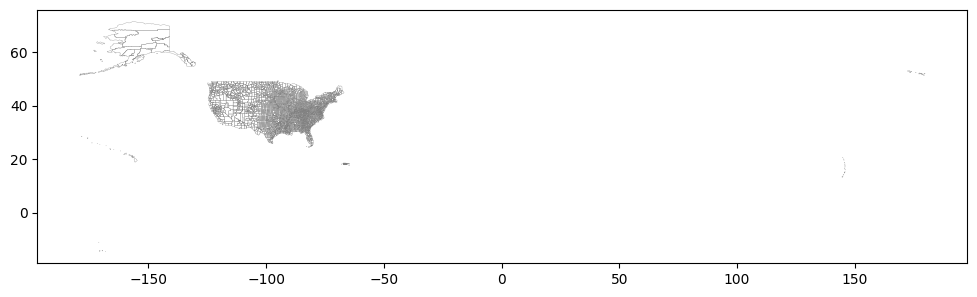

In [11]:
# Post aggregation for 1979

plot_climate_data(
    data=attribution_output_data,  
    data_type='county',
    usa_counties=usa_counties,  
    column_name='diff_suicide',
    start_year=2016,
    end_year=2020,
    title="Average deltas 2016-2020",
    value_min=-5,
    value_max=30,
    color_map="coolwarm",
    lon_bounds=(-130, -65),
    lat_bounds=(23, 50),
    key = "adm2_id"
)

In [8]:
attribution_output_data

,year,month,num_of_suicide,suiciderate,adm2_id,statename,countyname,date,y_hat_era5,y_hat_gdnat,ID_1,ID_2,diff_suicide
0,1980,1,0,NaN,13001,NaN,NaN,1980-01-01,0.066440,0.137301,13,1,-0.070861
1,1980,1,0,NaN,13083,NaN,NaN,1980-01-01,0.024402,0.094541,13,83,-0.070139
2,1980,1,0,NaN,17039,NaN,NaN,1980-01-01,-0.029225,0.084362,17,39,-0.113587
3,1980,1,0,NaN,22031,NaN,NaN,1980-01-01,0.066957,0.135230,22,31,-0.068273
4,1980,1,0,NaN,29057,NaN,NaN,1980-01-01,-0.014274,0.091063,29,57,-0.105337
...,...,...,...,...,...,...,...,...,...,...,...,...,...
425275,1988,8,0,0.000000,46137,South Dakota,Ziebach,1988-08-01,0.146365,0.150497,46,137,-0.004132
425276,1988,9,0,0.000000,46137,South Dakota,Ziebach,1988-09-01,0.093682,0.093388,46,137,0.000294
425277,1988,10,1,45.620438,46137,South Dakota,Ziebach,1988-10-01,0.084011,0.094899,46,137,-0.010888
425278,1988,11,0,0.000000,46137,South Dakota,Ziebach,1988-11-01,0.064230,0.065947,46,137,-0.001717


     ID_1  ID_2  COUNTYNS  GEOID        NAME           NAMELSAD LSAD CLASSFP  \
0      01     1  00161526   1001     Autauga     Autauga County   06      H1   
1      01     3  00161527   1003     Baldwin     Baldwin County   06      H1   
2      01     5  00161528   1005     Barbour     Barbour County   06      H1   
3      01     7  00161529   1007        Bibb        Bibb County   06      H1   
4      01     9  00161530   1009      Blount      Blount County   06      H1   
...   ...   ...       ...    ...         ...                ...  ...     ...   
3223   72   151  01804556  72151     Yabucoa  Yabucoa Municipio   13      H1   
3224   72   153  01804557  72153       Yauco    Yauco Municipio   13      H1   
3225   78    10  02378248  78010   St. Croix   St. Croix Island   10      H4   
3226   78    20  02378249  78020    St. John    St. John Island   10      H4   
3227   78    30  02378250  78030  St. Thomas  St. Thomas Island   10      H4   

      MTFCC CSAFP  ... METDIVFP FUNCSTA

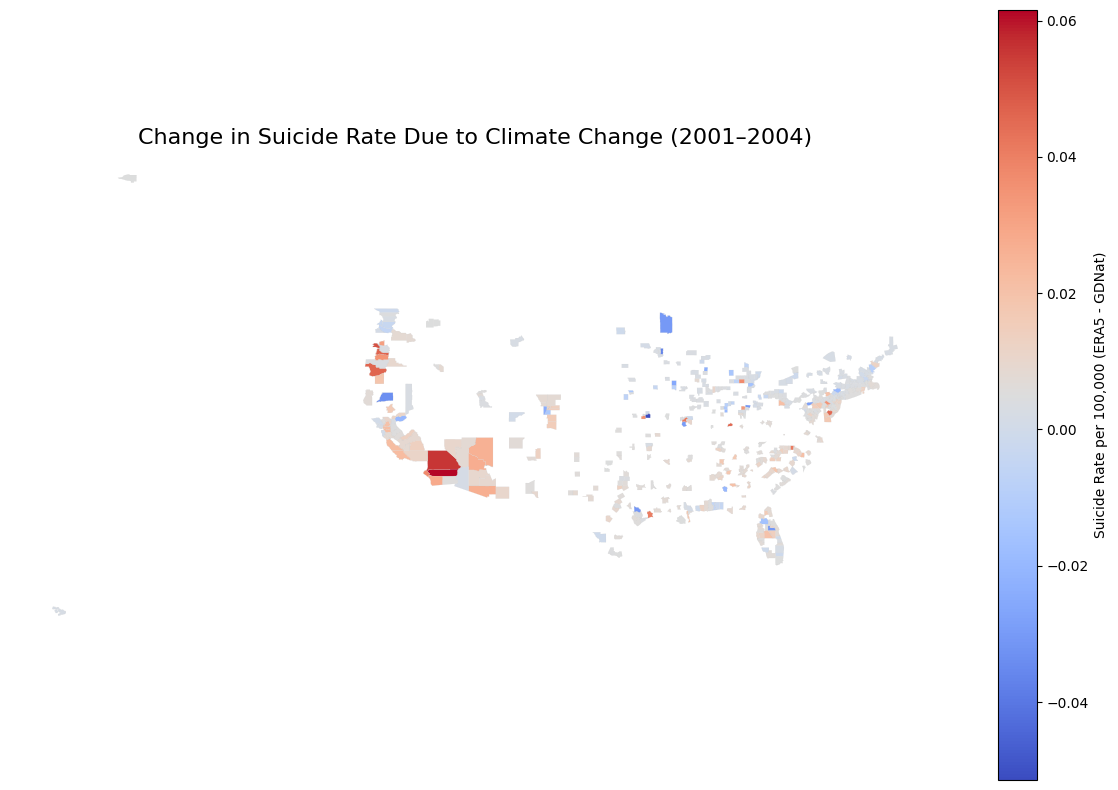

In [21]:
import matplotlib.pyplot as plt

# Filter to 2001–2004
df_filtered = attribution_output_data[attribution_output_data["year"].between(2000, 2003)]
# print(df_filtered)
#print("nas in df filtered")
#print(df_filtered.isna().sum())
# none

# Average over 2001–2004
county_diff = df_filtered.groupby("adm2_id")["diff_suicide"].mean().reset_index()
#print(county_diff)
#print("nas after doing mean")
#print(county_diff.isna().sum())

# Merge with shapefile
usa_counties["GEOID"] = usa_counties["GEOID"].astype(int)
gdf_merged = usa_counties.merge(county_diff, left_on="GEOID", right_on="adm2_id", how="left")

print(gdf_merged)
print("nas after merging")
print(gdf_merged.isna().sum())

# Filter to mainland USA
mainland = gdf_merged[~gdf_merged["ID_1"].isin([2, 15, 72, 78])]

# Plot
fig, ax = plt.subplots(figsize=(15, 10))
mainland.plot(column="diff_suicide", cmap="coolwarm", linewidth=0.1,
              edgecolor="0.8", legend=True, ax=ax,
              legend_kwds={"label": "Suicide Rate per 100,000 (ERA5 - GDNat)"})

ax.set_title("Change in Suicide Rate Due to Climate Change (2001–2004)", fontsize=16)
ax.axis("off")
plt.show()


In [28]:
era5_folderpath = os.path.join("merged", "USA")
era5_filename = "USA_adm2_1968_2004_monthly.dta"
era5_filepath = os.path.join(dir_path, era5_folderpath, era5_filename)

# Load the Stata file
df = pd.read_stata(era5_filepath)

# Filter to 2000-2003 (inclusive)
df_filtered = df[df["year"].between(2000, 2004)]

# Count unique counties
unique_counties = df_filtered['adm2_id'].nunique()
print(f"Unique counties from 2000 to 2003: {unique_counties}")


Unique counties from 2000 to 2003: 529


In [31]:

era5_filepath = "/global/scratch/users/yougsanghvi/data/climatedata/USA/usa_adm2_poly_1968_2004_monthly.dta"

# Load the Stata file
df = pd.read_stata(era5_filepath)

# Filter to 2000-2003 (inclusive)
df_filtered = df[df["year"].between(2000, 2004)]

# Count unique counties
unique_counties = df_filtered['adm2_id'].nunique()
print(f"Unique counties from 2000 to 2003: {unique_counties}")


Unique counties from 2000 to 2003: 324


In [26]:
geoids = set(usa_counties["GEOID"])
adm2_ids = set(county_diff["adm2_id"])

print("adm2_ids not in GEOID:", len(adm2_ids - geoids))
print("GEOID not in adm2_ids:", len(geoids - adm2_ids))
print("Overlap:", len(geoids & adm2_ids))
print("Total adm2_id:", len(adm2_ids))
print("Total GEOID:", len(geoids))

# Number of unique counties in the filtered dataset (2001-2004)
num_counties_filtered = df_filtered['adm2_id'].nunique()
print(f"Unique counties in filtered data: {num_counties_filtered}")

# Number of unique counties after grouping and averaging
num_counties_meaned = county_diff['adm2_id'].nunique()
print(f"Unique counties after averaging: {num_counties_meaned}")

# Number of unique counties after grouping and averaging
num_counties_og = attribution_output_data['adm2_id'].nunique()
print(f"Unique counties originally: {num_counties_og}")



adm2_ids not in GEOID: 0
GEOID not in adm2_ids: 2723
Overlap: 505
Total adm2_id: 505
Total GEOID: 3228
Unique counties in filtered data: 505
Unique counties after averaging: 505
Unique counties originally: 3040


In [29]:
gdf_merged
print(gdf_merged.isna().any())

ID_1            False
ID_2            False
COUNTYNS        False
GEOID           False
NAME            False
NAMELSAD        False
LSAD            False
CLASSFP         False
MTFCC           False
CSAFP            True
CBSAFP           True
METDIVFP         True
FUNCSTAT        False
ALAND           False
AWATER          False
INTPTLAT        False
INTPTLON        False
ID_0            False
geometry        False
adm2_id          True
diff_suicide     True
dtype: bool


In [26]:
# Filter years 2001-2004
df_filtered = attribution_output_data[attribution_output_data["year"].between(2001, 2004)]

# Get sorted unique year-month pairs
unique_times = df_filtered[["year", "month"]].drop_duplicates().sort_values(["year", "month"])

print(unique_times.reset_index(drop=True))


    year  month
0   2001      1
1   2001      2
2   2001      3
3   2001      4
4   2001      5
5   2001      6
6   2001      7
7   2001      8
8   2001      9
9   2001     10
10  2001     11
11  2001     12
12  2002      1
13  2002      2
14  2002      3
15  2002      4
16  2002      5
17  2002      6
18  2002      7
19  2002      8
20  2002      9
21  2002     10
22  2002     11
23  2002     12
24  2003      1
25  2003      2
26  2003      3
27  2003      4
28  2003      5
29  2003      6
30  2003      7
31  2003      8
32  2003      9
33  2003     10
34  2003     11
35  2003     12
36  2004      1
37  2004      2
38  2004      3
39  2004      4
40  2004      5
41  2004      6
42  2004      7
43  2004      8
44  2004      9
45  2004     10
46  2004     11
47  2004     12


In [31]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_time_series_by_location(
    data_df,               # The main DataFrame containing your time series data (e.g., stagg_usa_data)
    location_mapping_df,   # DataFrame with location names and IDs (e.g., usa_counties)
    location_name_col,     # Column name in location_mapping_df for the human-readable name (e.g., "NAME")
    location_id_col_map,   # Column name in location_mapping_df for the ID (e.g., "GEOID")
    data_id_col,           # Column name in data_df for the ID (e.g., "poly_id")
    target_location_name,  # The specific name of the location to plot (e.g., "New York")
    year_col,              # Column name for the year (e.g., "year")
    month_col,             # Column name for the month (e.g., "month")
    time_series_value_col, # Column name for the time series value to plot (e.g., "order_1_daily_avg")
    plot_title="Time Series Plot", # Full title for the plot
    y_label="Value",       # Y-axis label
    aggregate_annually=False, # If True, data will be averaged annually
    start_year=None,       # New parameter: Optional start year for filtering
    end_year=None          # New parameter: Optional end year for filtering
):
    """
    Generates a time series plot for a specific location within a dataset,
    with options to aggregate data annually and filter by a year range.

    Args:
        data_df (pd.DataFrame): The DataFrame containing the time series data.
        location_mapping_df (pd.DataFrame): DataFrame containing location names and their corresponding IDs.
        location_name_col (str): The name of the column in `location_mapping_df` that holds the location's human-readable name.
        location_id_col_map (str): The name of the column in `location_mapping_df` that holds the location's ID.
        data_id_col (str): The name of the column in `data_df` that holds the location's ID.
        target_location_name (str): The specific name of the location (e.g., "New York", "Alameda County")
                                    for which to generate the plot.
        year_col (str): The name of the column in `data_df` that holds the year.
        month_col (str): The name of the column in `data_df` that holds the month.
        time_series_value_col (str): The name of the column in `data_df` that holds the
                                     time series values to be plotted.
        plot_title (str, optional): The complete title for the plot. Defaults to "Time Series Plot".
        y_label (str, optional): The label for the Y-axis. Defaults to "Value".
        aggregate_annually (bool, optional): If True, the `time_series_value_col` will be
                                             averaged annually before plotting. Defaults to False.
        start_year (int, optional): The starting year for the data range (inclusive). If None, no lower bound.
        end_year (int, optional): The ending year for the data range (inclusive). If None, no upper bound.

    Returns:
        None: Displays the plot.
    """
    try:
        # Find the specific location ID directly by name from the mapping DataFrame
        chosen_location_id = location_mapping_df.loc[
            location_mapping_df[location_name_col] == target_location_name, location_id_col_map
        ].values

        if len(chosen_location_id) == 0:
            print(f"Error: Location '{target_location_name}' not found in the mapping data.")
            return
        chosen_location_id = chosen_location_id[0]

        print(f"Found ID for {target_location_name}: {chosen_location_id}")

        # Filter the main data for the chosen location
        chosen_location_data = data_df[data_df[data_id_col] == chosen_location_id].copy()

        if chosen_location_data.empty:
            print(f"Error: No data found for ID '{chosen_location_id}' ({target_location_name}) in the main dataset.")
            return

        # Apply year range filtering if specified
        if start_year is not None:
            chosen_location_data = chosen_location_data[chosen_location_data[year_col] >= start_year]
        if end_year is not None:
            chosen_location_data = chosen_location_data[chosen_location_data[year_col] <= end_year]

        if chosen_location_data.empty:
            print(f"Warning: No data remaining for ID '{chosen_location_id}' ({target_location_name}) after applying year filters ({start_year}-{end_year}).")
            return


        print(f"Data for {target_location_name} (first 5 rows):")
        print(chosen_location_data.head())

        if aggregate_annually:
            print(f"Aggregating '{time_series_value_col}' annually by average...")
            chosen_location_data = chosen_location_data.groupby(year_col)[time_series_value_col].mean().reset_index()
            # Create a datetime column using only the year for aggregated data
            chosen_location_data["date"] = pd.to_datetime(chosen_location_data[year_col], format='%Y')
            # Adjust plot title for aggregated data
            current_plot_title = f"Annual Average {plot_title.replace('Monthly Average', '').strip()} - {target_location_name}"
        else:
            # Sort by year and month for non-aggregated data
            chosen_location_data = chosen_location_data.sort_values([year_col, month_col])
            # Create a datetime column for plotting
            chosen_location_data["date"] = pd.to_datetime(
                dict(
                    year=chosen_location_data[year_col],
                    month=chosen_location_data[month_col],
                    day=1 # Assume first day of the month for date creation
                )
            )
            current_plot_title = plot_title


        # Plot
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(
            chosen_location_data["date"],
            chosen_location_data[time_series_value_col],
            marker="o",
            linestyle="-"
        )

        ax.set_title(current_plot_title)
        ax.set_xlabel("Date")
        ax.set_ylabel(y_label)
        ax.grid(True)

        plt.tight_layout() # Adjust layout to prevent labels from overlapping
        plt.show()

    except KeyError as e:
        print(f"Error: Missing expected column - {e}. Please check your column names.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


--- Example 1: Plotting New York County's Impact ---
Found ID for New York: 36061
Data for New York (first 5 rows):
        year  month  y_hat_gdnat  poly_id_int  num_of_suicide  suiciderate  \
538189  1980      1     0.070416        36061             0.0          NaN   
538190  1980      2     0.043043        36061             0.0          NaN   
538191  1980      3     0.115166        36061             0.0          NaN   
538192  1980      4     0.153423        36061             0.0          NaN   
538193  1980      5     0.157832        36061             0.0          NaN   

       statename countyname        date  y_hat_era5  diff_suicide  
538189       NaN        NaN  1980-01-01    0.010602     -0.059814  
538190       NaN        NaN  1980-02-01    0.025492     -0.017551  
538191       NaN        NaN  1980-03-01    0.023391     -0.091775  
538192       NaN        NaN  1980-04-01    0.046757     -0.106666  
538193       NaN        NaN  1980-05-01    0.119414     -0.038418  
Aggrega

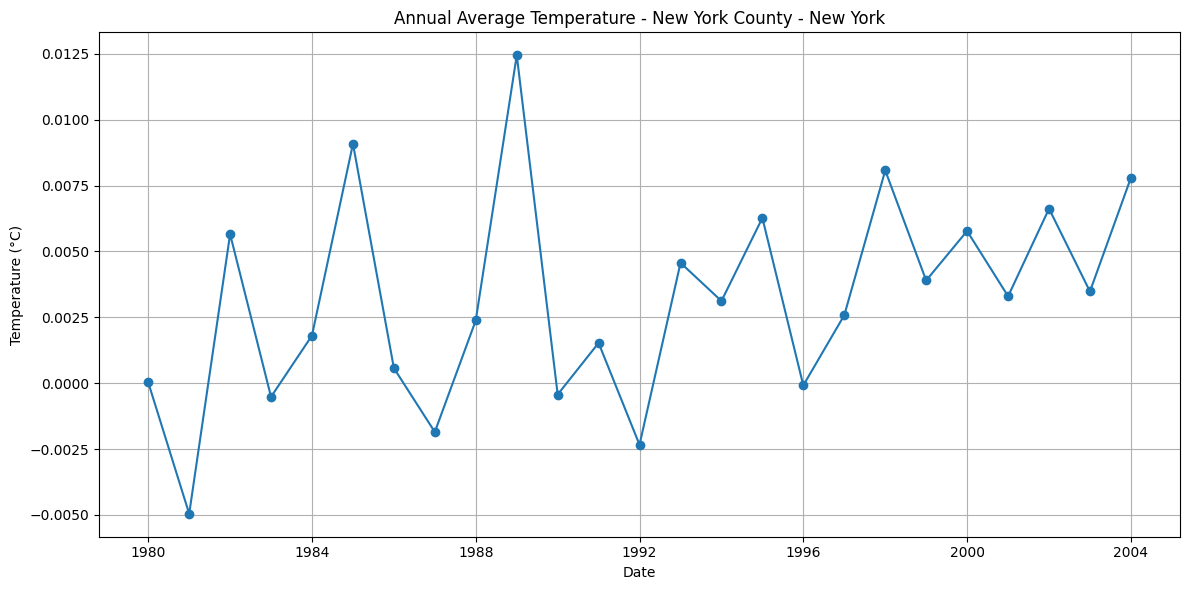

In [32]:
print("--- Example 1: Plotting New York County's Impact ---")
plot_time_series_by_location(
    data_df=attribution_output_data,
    location_mapping_df=usa_counties,
    location_name_col="NAME",
    location_id_col_map="GEOID",
    data_id_col="poly_id_int",
    target_location_name="New York", 
    year_col="year",
    month_col="month",
    time_series_value_col="diff_suicide",
    plot_title="Monthly Average Temperature - New York County", # Full custom title
    y_label="Temperature (°C)",
    aggregate_annually = True,
    start_year = 1980 # need to investiage some issues in 1979
)

In [36]:
attribution_output_data.isnull().sum()

year                   0
month                  0
y_hat_gdnat        48008
poly_id_int            0
num_of_suicide    514111
suiciderate       519151
statename         516631
countyname        516631
date              514111
y_hat_era5        514111
diff_suicide      562119
dtype: int64